In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
#Load Dataset
df = pd.read_csv("visa_dataset.csv")

## Milestone 2 - Exploratory Data Analysis &amp; Feature Engineering

In [27]:
df.shape

(50000, 11)

### 1. Visual EDA — Histograms for All Numeric Features

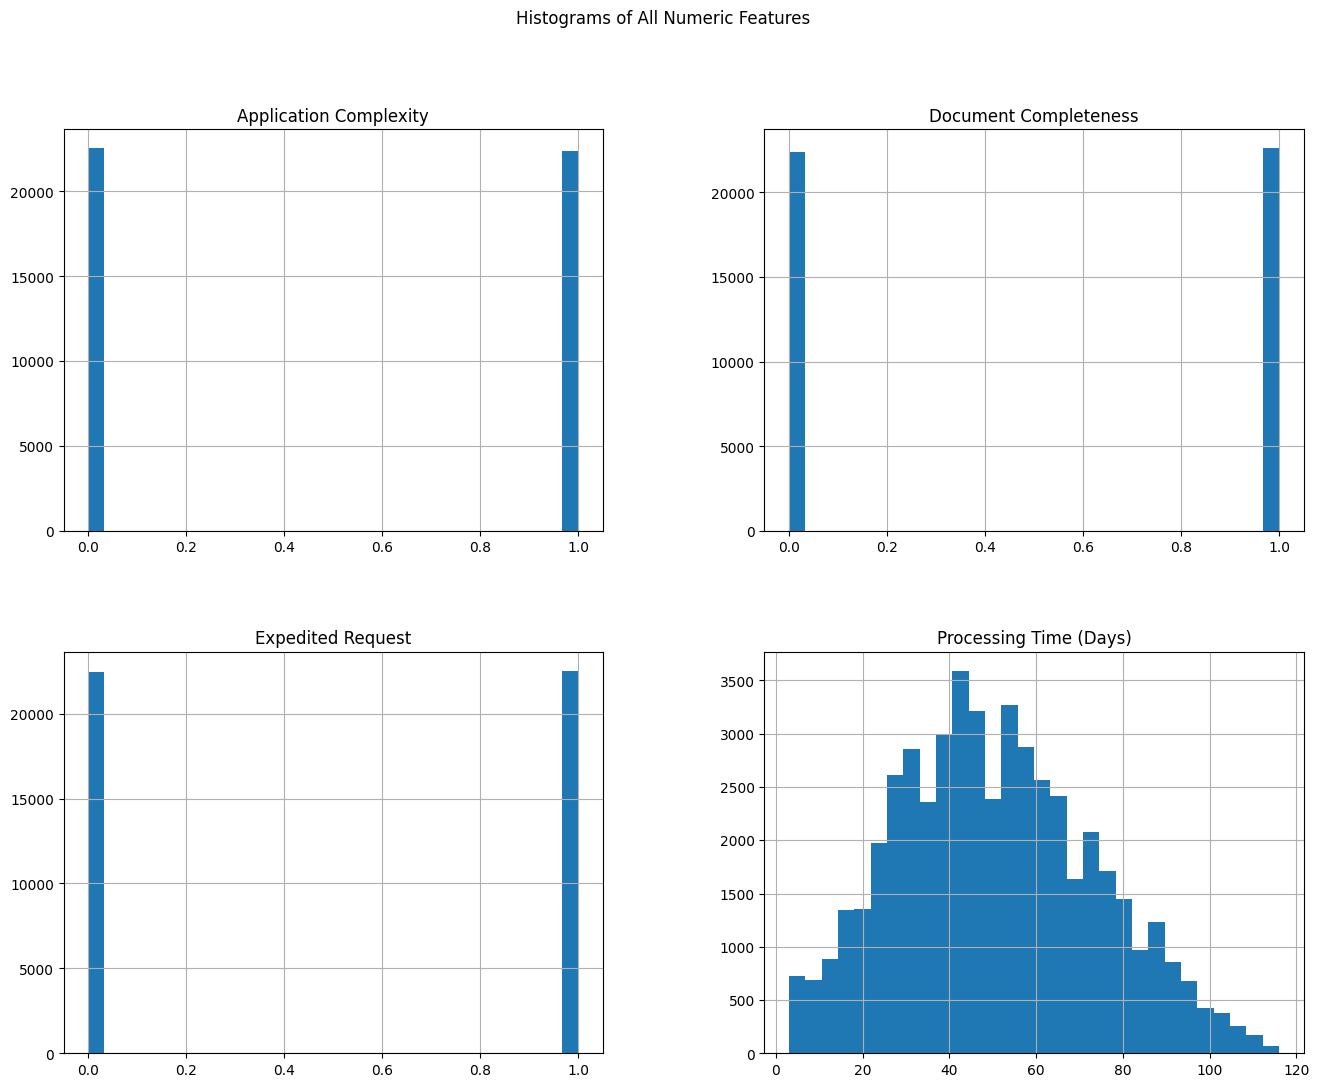

In [29]:
num_cols = df.select_dtypes(include=['int64','float64']).columns

df[num_cols].hist(figsize=(16,12), bins=30)
plt.suptitle("Histograms of All Numeric Features")
plt.show()

**Application Complexity:** Binary distribution showing applications are either simple or complex.

**Document Completeness:** Binary pattern indicating documents are either complete or incomplete.

**Expedited Request:** Clearly shows both 0 and 1, meaning some applicants request expedited processing while many do not.

**Processing Time (Days):** Bell-shaped curve showing most cases take around 30–60 days.


### 2. Categorical Feature Distribution

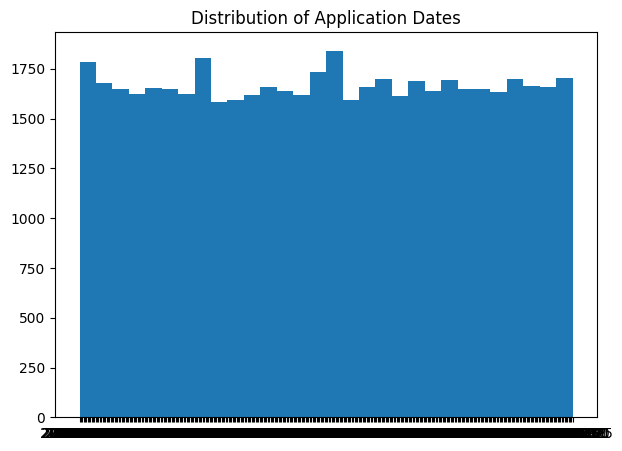

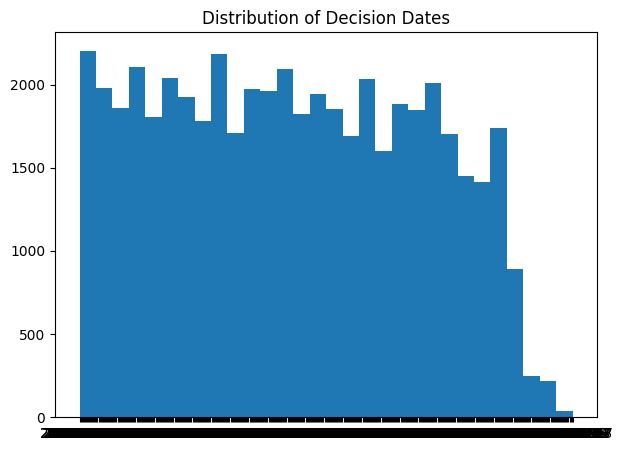

In [33]:
plt.figure(figsize=(7,5))
plt.hist(df['Application Date'], bins=30)
plt.title("Distribution of Application Dates")
plt.show()

plt.figure(figsize=(7,5))
plt.hist(df['Decision Date'], bins=30)
plt.title("Distribution of Decision Dates")
plt.show()



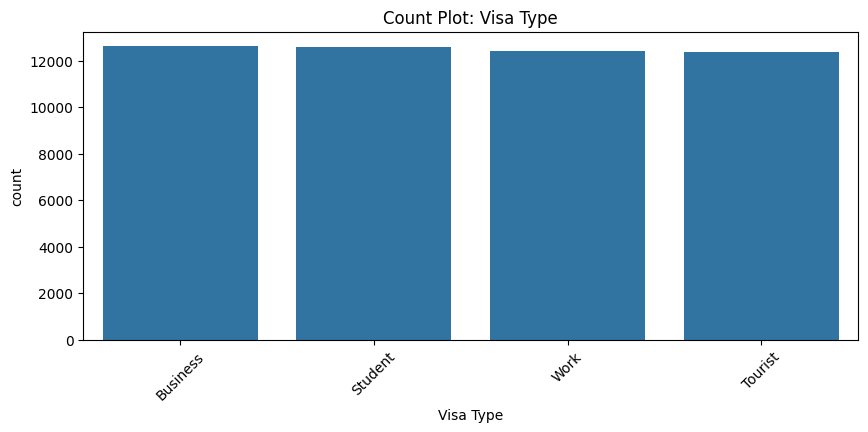

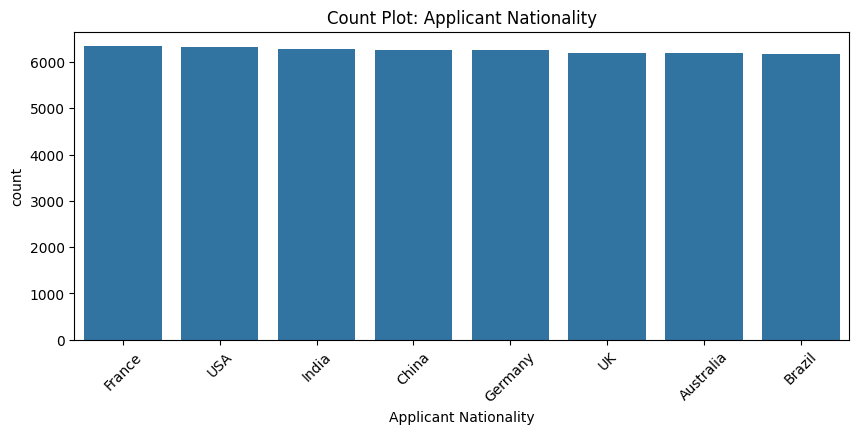

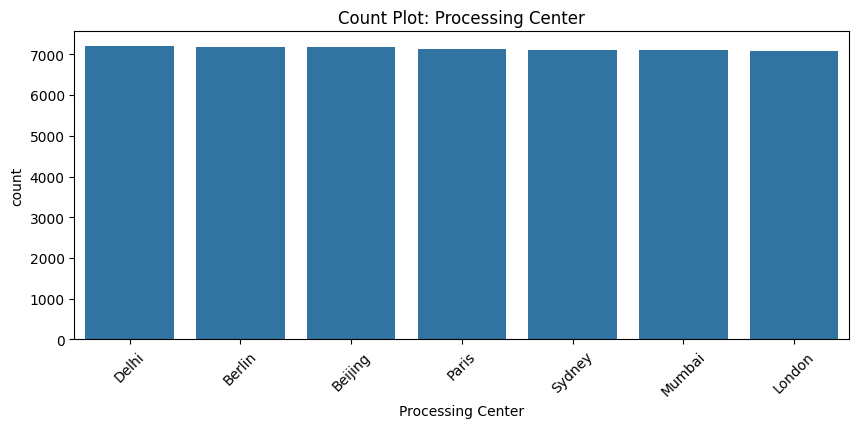

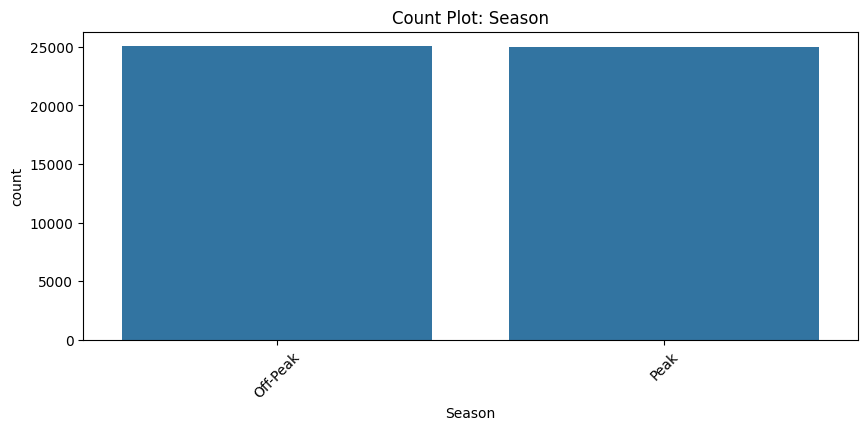

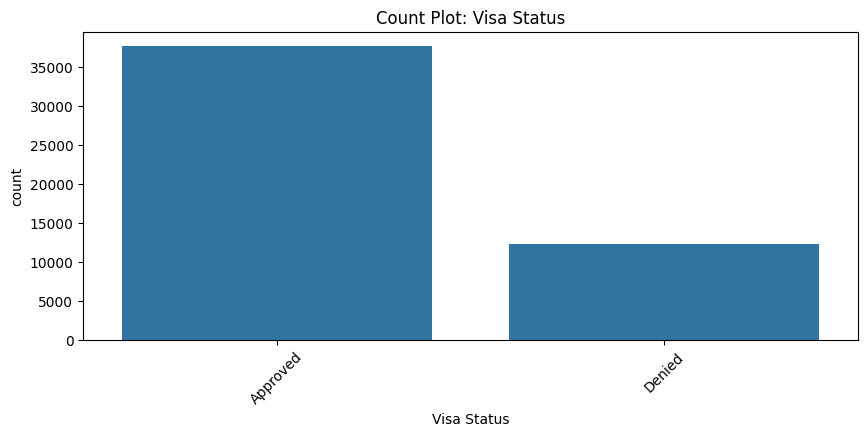

In [35]:
cat_cols = df.select_dtypes(include=['object']).columns

exclude = ['Application Date', 'Decision Date']
cat_cols = [col for col in cat_cols if col not in exclude]

for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count Plot: {col}")
    plt.xticks(rotation=45)
    plt.show()

Most categorical features are evenly distributed, showing balance across categories.

Only the 'Approved' vs 'Denied' categories show clear variation, indicating approvals are significantly higher than denials.


### 3. Processing Time vs Categorical Features

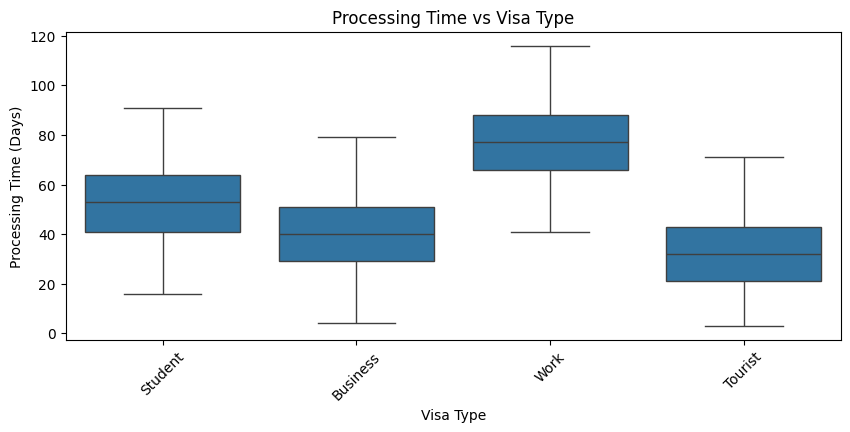

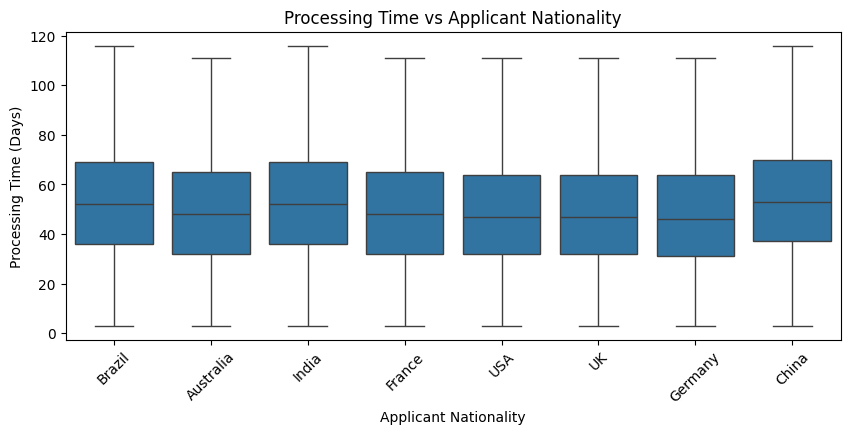

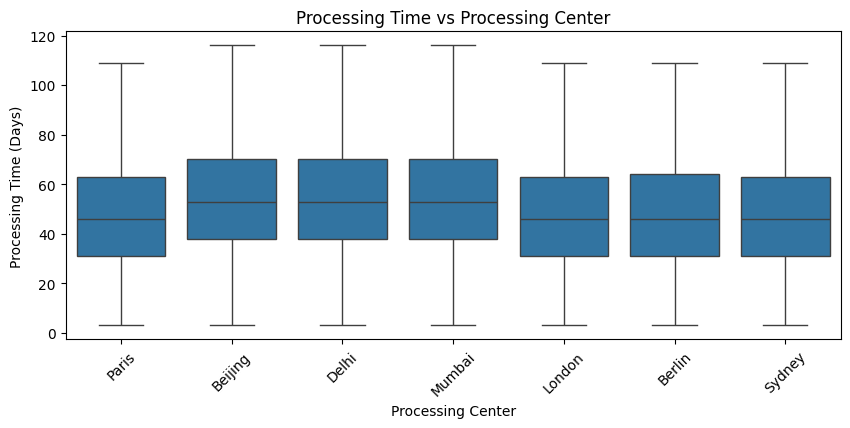

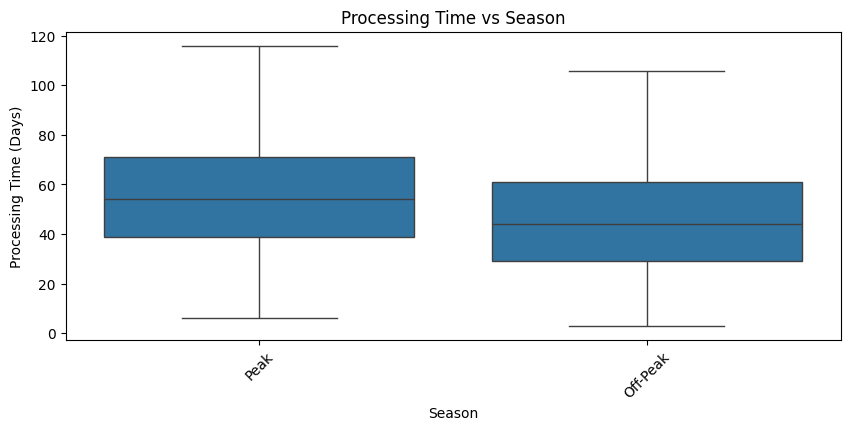

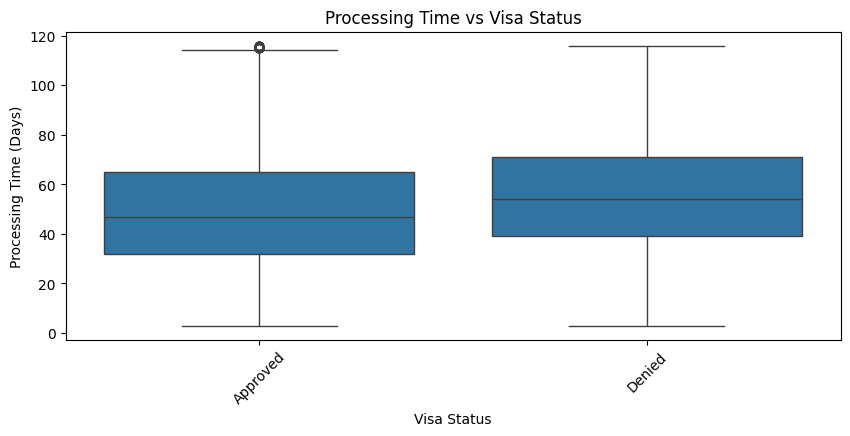

In [36]:
for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=df, x=col, y="Processing Time (Days)")
    plt.title(f"Processing Time vs {col}")
    plt.xticks(rotation=45)
    plt.show()

**1. Processing Time vs Visa Type:**  
Work visas take the longest, business visas the fastest, showing visa category strongly influences processing time.

**2. Processing Time vs Applicant Nationality:**  
Processing times vary very little by nationality, indicating nationality has minimal impact on overall delay.

**3. Processing Time vs Processing Center:**  
Different visa centers show different processing speeds, meaning location of application strongly affects processing time.

**4. Processing Time vs Season:**  
Peak season applications take significantly longer than off-peak, confirming seasonality impacts workload.

**5. Processing Time vs Visa Status:**  
Denied visas generally take slightly longer to process than approved ones, suggesting complex or suspicious cases delay decisions.


### 4. Processing Time vs Numeric Features

In [42]:
# Create date-based numeric columns
df["Application Date"] = pd.to_datetime(df["Application Date"])
df["Decision Date"] = pd.to_datetime(df["Decision Date"])

df["Application_Month"] = df["Application Date"].dt.month
df["Application_DayOfWeek"] = df["Application Date"].dt.dayofweek
df["Application_WeekOfYear"] = df["Application Date"].dt.isocalendar().week.astype(int)

df["Decision_Month"] = df["Decision Date"].dt.month
df["Decision_DayOfWeek"] = df["Decision Date"].dt.dayofweek
df["Decision_WeekOfYear"] = df["Decision Date"].dt.isocalendar().week.astype(int)


In [43]:
num_cols = [
    "Application_Month",
    "Application_DayOfWeek",
    "Application_WeekOfYear",
    "Decision_Month",
    "Decision_DayOfWeek",
    "Decision_WeekOfYear",
    "Application Complexity",
    "Document Completeness",
    "Expedited Request"
]


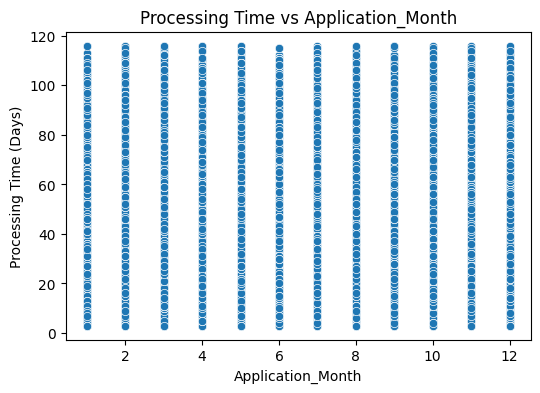

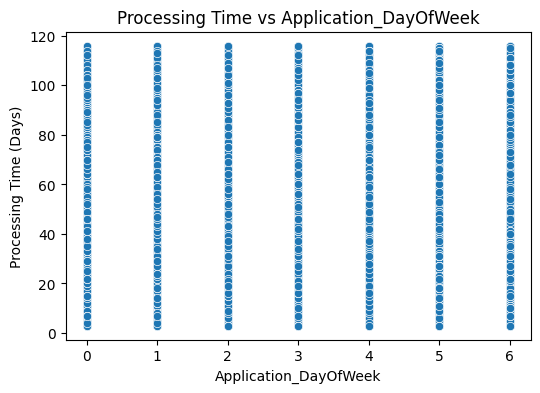

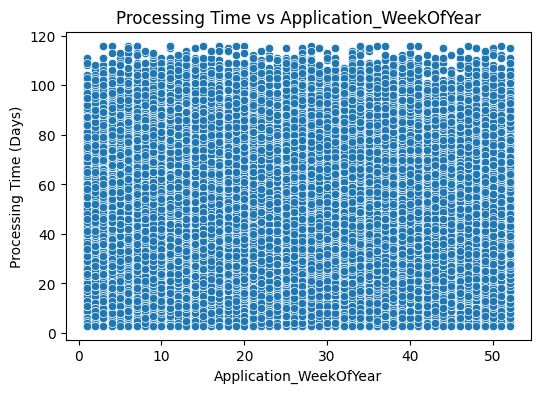

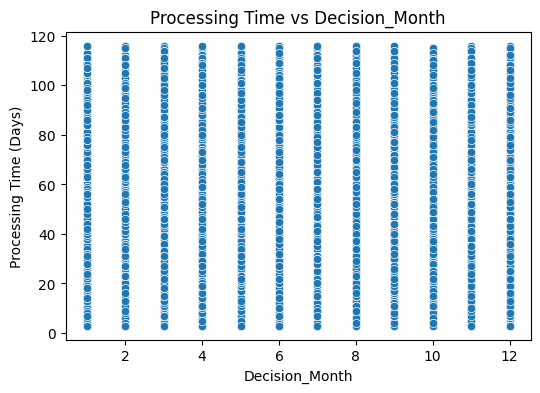

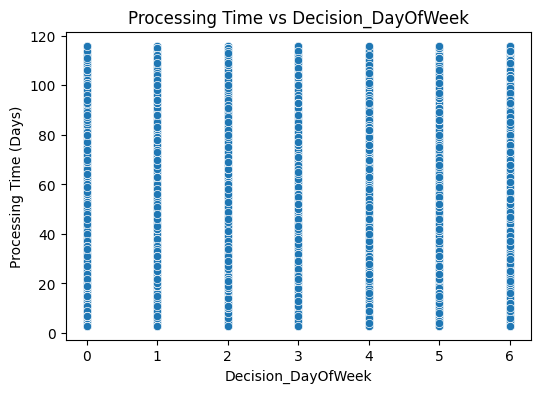

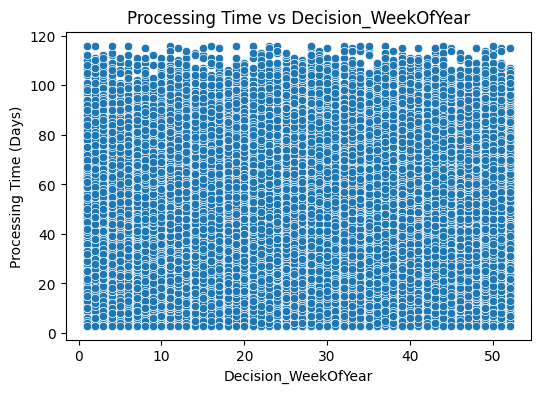

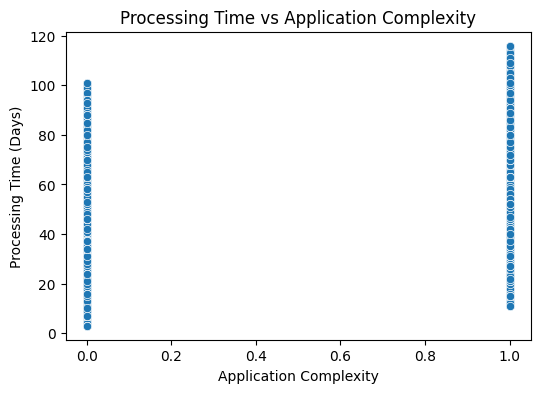

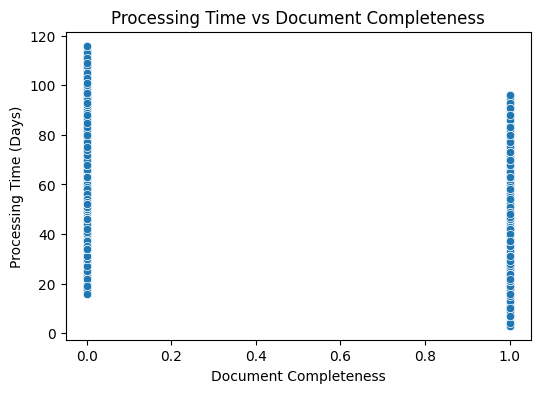

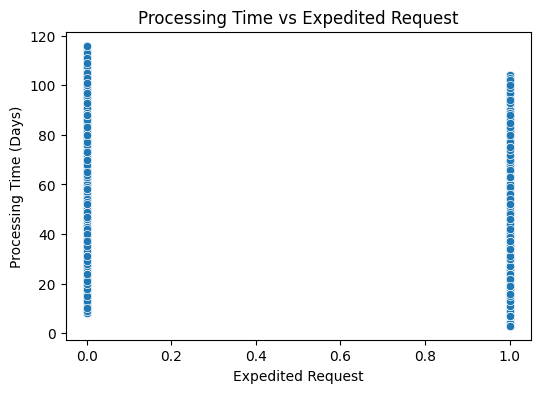

In [44]:
for col in num_cols:
    if col != "Processing Time (Days)":
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[col], y=df["Processing Time (Days)"])
        plt.title(f"Processing Time vs {col}")
        plt.show()


**Processing Time vs Application_Month:**  
Processing time does not vary by month; all months show a similar spread of days.

**Processing Time vs Application_DayOfWeek:**  
No noticeable pattern across weekdays; applications filed on any day show similar processing durations.

**Processing Time vs Application_WeekOfYear:**  
Processing time remains consistent across all weeks of the year, indicating no weekly seasonality.

**Processing Time vs Decision_Month:**  
Decision month has no visible impact; decisions take similar time regardless of month.

**Processing Time vs Decision_DayOfWeek:**  
Decision day of the week shows no trend; processing duration is uniform across weekdays.

**Processing Time vs Decision_WeekOfYear:**  
Decision week of the year shows a flat distribution, meaning decisions are processed uniformly across the year.

**Processing Time vs Application Complexity:**  
Both simple (0) and complex (1) applications show overlapping processing times, indicating complexity has minimal impact.

**Processing Time vs Document Completeness:**  
Complete and incomplete documents have almost identical processing time ranges, showing completeness does not strongly affect delay.

**Processing Time vs Expedited Request:**  
Expedited requests (1) and normal requests (0) have similar scatter patterns, indicating no real reduction in processing time despite requesting expedition.


### 5. Correlation Matrix (Numerical)

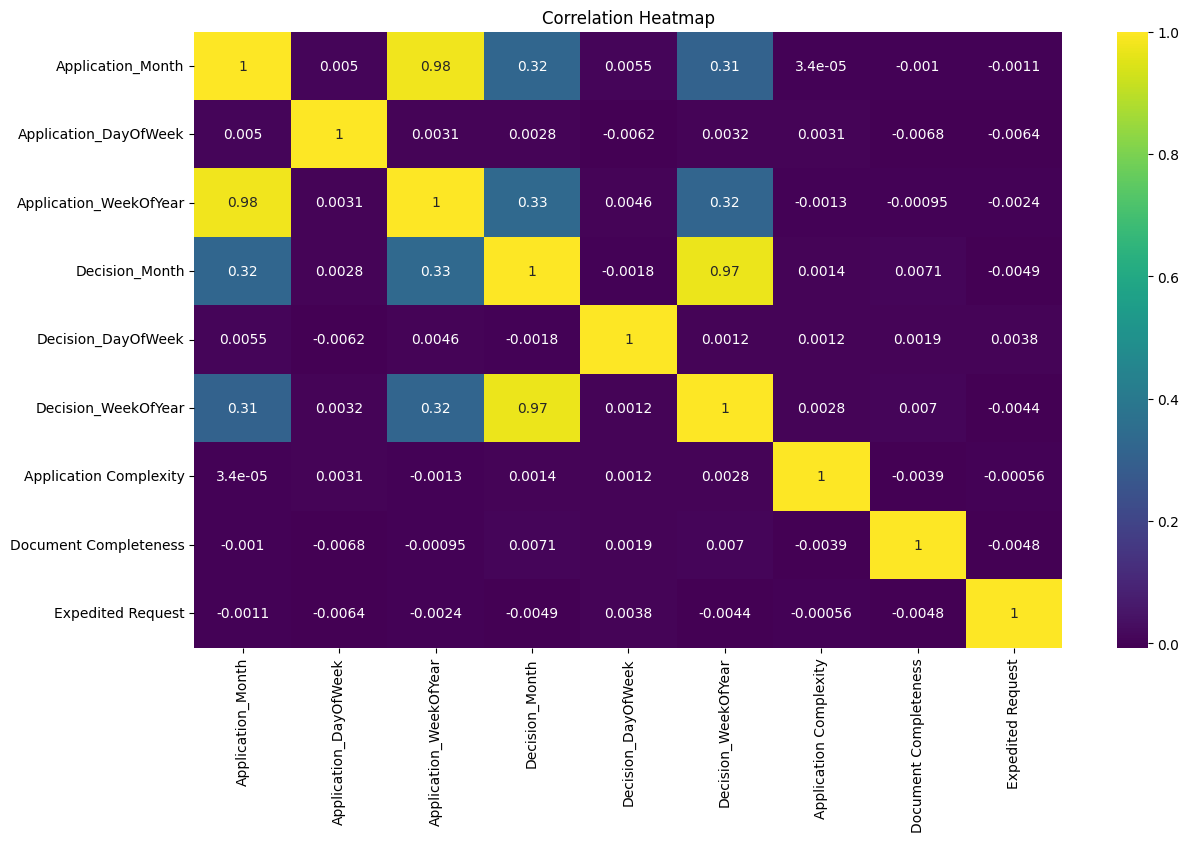

In [45]:
plt.figure(figsize=(14,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

**Correlation Heatmap Insights:**

**1. Strong correlations exist only within date-related features:**
- Application_Month ↔ Application_WeekOfYear (0.98)
- Decision_Month ↔ Decision_WeekOfYear (0.97)
  
These simply reflect natural calendar relationships, not meaningful predictive patterns.

**2. Application and Decision date features show moderate cross-correlation (≈0.30):**  
This happens because decision dates usually follow application dates by a fixed range, creating slight alignment.

**3. Day-of-week features show almost zero correlation with all other variables:**  
This confirms weekday has no influence on application or decision timing.

**4. Application Complexity, Document Completeness, and Expedited Request show near-zero correlation with all date features:**  
These attributes behave independently and do not follow any time-based pattern.

**5. No feature shows meaningful correlation with others (except calendar relationships):**  
This indicates the dataset is well-balanced and no major multicollinearity issues exist.


### 6. Feature Engineering

In [46]:
# Adding Seasonal Feature in the dataset
df["Season_Index"] = df["Application_Month"].apply(
    lambda m: 1 if m in [4,5,6] else
              2 if m in [7,8,9] else
              3 if m in [10,11,12] else
              4
)

In [48]:
# Country Level Feature (avg processing time)
country_avg = df.groupby("Applicant Nationality")["Processing Time (Days)"].mean()
df["Country_Avg_Processing"] = df["Applicant Nationality"].map(country_avg)

In [49]:
# Visa Type Average processing time
visa_avg = df.groupby("Visa Type")["Processing Time (Days)"].mean()
df["VisaType_Avg_Processing"] = df["Visa Type"].map(visa_avg)

In [54]:
# Processing Center Workload
center_load = df["Processing Center"].value_counts()
df["Center_Load"] = df["Processing Center"].map(center_load)

In [67]:
num_cols.append("Processing Time (Days)")

In [68]:
target_corr = df[num_cols].corr()["Processing Time (Days)"].sort_values(ascending=False)
print("Correlation with Processing Time:\n")
print(target_corr)

Correlation with Processing Time:

Processing Time (Days)    1.000000
Application Complexity    0.329518
Application_Month         0.007241
Application_WeekOfYear    0.006512
Decision_WeekOfYear       0.003415
Decision_Month            0.001874
Application_DayOfWeek     0.001126
Decision_DayOfWeek       -0.004227
Expedited Request        -0.261766
Document Completeness    -0.435442
Name: Processing Time (Days), dtype: float64


In [69]:
df

,Application Date,Decision Date,Visa Type,Applicant Nationality,Processing Center,Season,Application Complexity,Document Completeness,Expedited Request,Processing Time (Days),...,Application_Month,Application_DayOfWeek,Application_WeekOfYear,Decision_Month,Decision_DayOfWeek,Decision_WeekOfYear,Season_Index,Country_Avg_Processing,VisaType_Avg_Processing,Center_Load
0,2024-01-21,2024-03-10,Student,Brazil,Paris,Peak,0.0,NaN,0.0,49,...,1,6,3,3,6,10,4,53.788247,52.490159,7133
1,2024-10-20,2024-11-01,Business,Australia,Beijing,Off-Peak,0.0,1.0,1.0,12,...,10,6,42,11,4,44,3,48.986253,40.250139,7170
2,2024-07-06,2024-08-27,Business,India,Delhi,Peak,0.0,0.0,1.0,52,...,7,5,27,8,1,35,2,53.365332,40.250139,7199
3,2024-11-24,2025-01-27,Business,India,Beijing,Peak,0.0,0.0,0.0,64,...,11,6,47,1,0,5,3,53.365332,40.250139,7170
4,2024-09-20,2024-12-18,Work,France,Mumbai,Off-Peak,1.0,0.0,1.0,89,...,9,4,38,12,2,51,2,49.337068,77.326490,7110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2024-07-04,2024-08-07,Business,Brazil,Sydney,Off-Peak,0.0,0.0,1.0,34,...,7,3,27,8,2,32,2,53.788247,40.250139,7112
49996,2024-07-05,2024-08-11,Business,Australia,Mumbai,Peak,0.0,1.0,0.0,37,...,7,4,27,8,6,32,2,48.986253,40.250139,7110
49997,2024-11-28,2025-02-24,Work,China,Berlin,Peak,NaN,1.0,0.0,88,...,11,3,48,2,0,9,3,53.938019,77.326490,7190
49998,2024-04-03,2024-04-22,Tourist,Australia,Berlin,Off-Peak,NaN,0.0,1.0,19,...,4,2,14,4,0,17,1,48.986253,32.308525,7190


### Why Feature Engineering?

To improve the accuracy of visa processing time prediction, several informative features were engineered:

**Season Index**: Application month converted into seasonal groups (1–4) to capture seasonal variation in visa load.

**Country_Avg_Processing**: Average processing time for each applicant nationality, reflecting country-specific processing patterns.

**VisaType_Avg_Processing**: Mean processing time for each visa type, capturing differences in complexity across categories.

**Center_Load**: Number of applications handled by each processing center, representing workload impact on delays.

**Date-Based Features**: Extracted month, day of week, and week of year from both Application and Decision dates to capture temporal trends.

These engineered features help the model learn patterns related to seasonality, country behavior, visa complexity, and center workload—ultimately improving processing-time prediction.

In [70]:
# Save EDA Enhanced Dataset
df.to_csv("visa_dataset_feature_engineered.csv", index=False)
print("Milestone 2 Completed — EDA + Feature Engineering Saved")

Milestone 2 Completed — EDA + Feature Engineering Saved
